In [1]:
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from models_script import RegEffectModel
from sklearn.model_selection import train_test_split

# Load Data

In [2]:
# read the data
ratings_df = pd.read_csv('raw/ml-100k/u.data', sep = '\t', header = None, 
                      names = ['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df['timestamp'] = ratings_df['timestamp'].apply(datetime.fromtimestamp)

In [4]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 07:55:49
1,186,302,3,1998-04-04 11:22:22
2,22,377,1,1997-11-06 23:18:36
3,244,51,2,1997-11-26 21:02:03
4,166,346,1,1998-02-01 21:33:16


# Alternating Least Squares 

In [5]:
def RMSE(pred_val, true_val):
    
    return np.sqrt(mean_squared_error(pred_val, true_val))

In [6]:
class ALS():

    def __init__(self, n_factors=5, n_itr=5, reg_Pu=0, reg_Qi=0, random_seed=0, bias_effect=True):

        self.n_factors = n_factors
        self.n_itr = n_itr
        self.reg_Pu = reg_Pu
        self.reg_Qi = reg_Qi
        self.random_seed = random_seed
        self.bias_effect = bias_effect

    def _initial_param(self, X_train):

        X_train = X_train.copy()

        # initial rating matrix
        self.R = pd.pivot_table(data=X_train,
                                values='rating',
                                index='user_id',
                                columns='movie_id').fillna(0).values

        # define mapping relationship dict{old_index : new_index}
        self.user_map = self.map_id(X_train, 'user_id')
        self.movie_map = self.map_id(X_train, 'movie_id')

        # get number of users/movies from Rating Matrix
        self.n_users = self.R.shape[0]
        self.n_movies = self.R.shape[1]

        np.random.seed(self.random_seed)
        # initial P_u, Q_i, and the identity matrix
        self.P_u = 3 * np.random.rand(self.n_factors, self.n_users)  # k*n
        self.Q_i = 3 * np.random.rand(self.n_factors, self.n_movies)  # k*m
        self.I = np.identity(self.n_factors)  # k*k

        # The goal is to fillin the missing ratings if user_id or movie_id in training set
        # but not in testing set.
        # initial user bias, movie bias term, overall mean
        if self.bias_effect == True:
            self.baseline_algo = RegEffectModel(damping_term=25)
            self.baseline_algo.fit(X_train)
            self.b_u, self.b_i = self.baseline_algo.b_u.values, self.baseline_algo.b_i.values
        else:
            self.b_u = np.zeros(self.n_users)
            self.b_i = np.zeros(self.n_movies)

        self.u = X_train['rating'].mean()

    def fit(self, X_train):

        X_train = X_train.copy()
        self._initial_param(X_train)

        itr = 0
        while itr < self.n_itr:

            ########## Fix Q_i, Update P_u ##########
            # loop for each user
            for i, Ri in enumerate(self.R):

                # Determine the scale of penalities, lambdau, for each user

                # number of items user i has rated
                reg_scale_i = np.count_nonzero(Ri)
                # if no ratings in Rating Matrix
                if reg_scale_i == 0:
                    reg_scale_i = 1

                # Find indicies
                # get the array of nonzero indicies in row i for each user
                Ri_nonzero_idx = np.nonzero(Ri)[0]
                # select subset of row R associated with movies reviewd by user i -> find r_ui
                r_ui = self.R[i, Ri_nonzero_idx]
                # select subset of Q_i associated with movies by user i -> find qi_T
                qi = self.Q_i[:, Ri_nonzero_idx]

                # Compute
                # qi * ri
                bi = qi.dot(r_ui)
                # qi* qi.T + lambda_u * I
                Ai = qi.dot(qi.T) + self.reg_Pu * reg_scale_i * self.I

                # get p_ui
                self.P_u[:, i] = np.linalg.solve(Ai, bi)  # bi.dot(np.linalg.inv(Ai))

            ########## Fix P_u, Update Q_i ##########
            # loop for each movie
            for j, Rj in enumerate(self.R.T):

                # Determine the scale of penalities, lambdau, for each movie

                # number of items user i has rated
                reg_scale_j = np.count_nonzero(Rj)
                # if no ratings in Rating Matrix
                if reg_scale_j == 0:
                    reg_scale_j = 1

                # Find indicies
                # get the array of nonzero indicies in row i for each movie
                Rj_nonzero_idx = np.nonzero(Rj)[0]
                # select subset of row R associated with users who reviewed movie j -> find r_ui
                r_uj = self.R.T[j, Rj_nonzero_idx]
                # select subset of Q_i associated with users who reviewed movie j -> find pu
                pu = self.P_u[:, Rj_nonzero_idx]

                # Compute
                # qi * ri
                bj = pu.dot(r_uj)
                # qi* qi.T + lambda_u * I
                Aj = pu.dot(pu.T) + self.reg_Qi * reg_scale_j * self.I

                # get q_ui
                self.Q_i[:, j] = np.linalg.solve(Aj, bj)  # bj.dot(np.linalg.inv(Aj))

            itr += 1

    def predict(self, X_test):

        X_test = X_test.iloc[:, :3].copy()

        # find the mapping indexes
        check_id = X_test['user_id'].isin(
            self.user_map.keys()) & X_test['movie_id'].isin(self.movie_map.keys())

        # classify known-dataset and unknown-dataset
        X_known, X_unknown = X_test[check_id], X_test[-check_id]
        # by using map, find out new user/movie indexes
        user_inds = X_known['user_id'].map(self.user_map)
        movie_inds = X_known['movie_id'].map(self.movie_map)

        # make prediction
        rating_pred = np.array([
            self.P_u[:, u_ind].dot(self.Q_i[:, i_ind])
            for u_ind, i_ind in zip(user_inds, movie_inds)
        ])

        # assign predictions to original dataframe
        X_test.loc[check_id, 'rating'] = rating_pred

        # fillout missing values of ratings whose use_id or movie_id is not in trianing set
        if self.bias_effect == True:
            X_test.loc[-check_id, 'rating'] = self.baseline_algo.predict(X_unknown)
        else:
            X_test.loc[-check_id, 'rating'] = self.u

        # deal with some outliers from rating_pred
        min_rating = np.min(self.R[np.nonzero(self.R)])
        max_rating = np.max(self.R)
        X_test.loc[X_test['rating'] < min_rating, 'rating'] = min_rating
        X_test.loc[X_test['rating'] > max_rating, 'rating'] = max_rating

        return X_test['rating'].values

    def map_id(self, X, column_name):
        """
        @X(pd.dataframe): traning dataset
        @column_name(str): indicate column name for mapping

        @return(dict): return mapping relationships in dictionary
        """

        old_ids = np.unique(X[column_name])
        new_ids = np.arange(X[column_name].nunique())

        return dict(zip(old_ids, new_ids))


# Evaluation

In [15]:
X_train, X_test = train_test_split(ratings_df, test_size=0.2, shuffle = True, random_state=0)

In [19]:
X_train.shape

(80000, 4)

## 5-fold

In [49]:
n_splits = 5
max_itr = 51
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_itr))
test_errs = np.zeros((n_splits, max_itr))

In [37]:
# 5-fold evaluations
# might take a long time!!!
for i_fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print("i_fold={}".format(i_fold))
    # get training set and testing set
    train_df, test_df = X_train.iloc[train_index, :],X_train.iloc[test_index, :] 
    
    for j in range(max_itr):
        # initial model
        ALS_model = ALS(n_factors=20, n_itr = j, reg_Pu=0.1, reg_Qi=0.1, random_seed=0, bias_effect=True)
        ALS_model.fit(train_df)
        
        train_pred = ALS_model.predict(train_df)
        train_errs[i_fold, j] = RMSE(train_pred, train_df['rating'])
        
        
        test_pred = ALS_model.predict(test_df)
        test_errs[i_fold, j] = RMSE(test_pred, test_df['rating'])

If you can get all RMSEs from training sets and testing sets, you can calculate the mean from 5-folds and create a comparision plot between training sets and testing sets under different iterations (given n_factors/K = 20).

## Find Optimal Iteration

In [50]:
## Use last fold
n_splits = 5
max_itr = 51
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
train_errs = np.zeros((n_splits, max_itr))
test_errs = np.zeros((n_splits, max_itr))

# 5-fold evaluations
for i_fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    # get training set and testing set
    train_df, test_df = X_train.iloc[train_index, :],X_train.iloc[test_index, :]

In [55]:
train_errs = np.zeros(max_itr)
test_errs = np.zeros(max_itr)

In [56]:
for j in range(max_itr):
    # initial model
    ALS_model = ALS(n_factors=20, n_itr = j, reg_Pu=0.1, reg_Qi=0.1, random_seed=0, bias_effect=True)
    ALS_model.fit(train_df)

    train_pred = ALS_model.predict(train_df)
    train_errs[j] = RMSE(train_pred, train_df['rating'])


    test_pred = ALS_model.predict(test_df)
    test_errs[j] = RMSE(test_pred, test_df['rating'])

In [59]:
errs_df = pd.DataFrame({'n_itr' : np.arange(max_itr),'train_errs': train_errs, 'test_errs': test_errs})

In [106]:
# errs_df.to_csv(r'ALS_itr_results.csv', index = False, header = True)

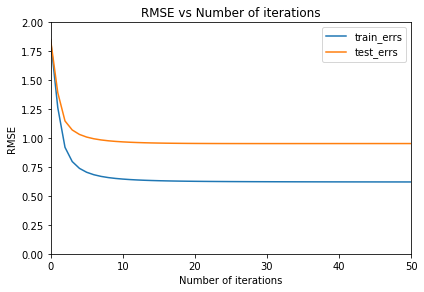

In [116]:
fig, ax = plt.subplots()
errs_df['train_errs'].plot(style='-', ax=ax)
errs_df['test_errs'].plot(style='-', ax=ax)
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.ylim([0, 2])
plt.tight_layout()
plt.legend()
plt.title('RMSE vs Number of iterations')
# plt.savefig('ALS_itr.png', dpi=300)
plt.show()

Given n_factors = 20, we find that RMSE will not decrease significantly after 20 iterations. Thus, we will use n_itr = 20 for finding optimal K values

## Find Optimal K

In [73]:
k_list = [1, 2, 5, 10, 20, 50, 100]
train_errs2 = np.zeros(len(k_list))
test_errs2 = np.zeros(len(k_list))

In [79]:
for i in range(len(k_list)):
    # initial model
    ALS_model = ALS(n_factors=k_list[i], n_itr = 20, reg_Pu=0.1, reg_Qi=0.1, random_seed=0, bias_effect=True)
    ALS_model.fit(train_df)

    train_pred = ALS_model.predict(train_df)
    train_errs2[i] = RMSE(train_pred, train_df['rating'])

    test_pred = ALS_model.predict(test_df)
    test_errs2[i] = RMSE(test_pred, test_df['rating'])

In [103]:
errs_df2 = pd.DataFrame({'n_factors' : k_list,'train_errs': train_errs2, 'test_errs': test_errs2})

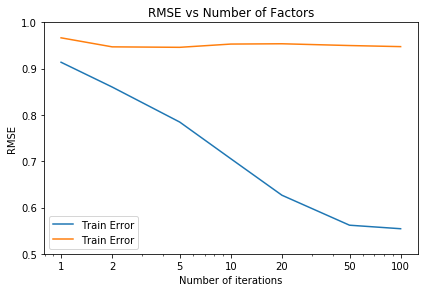

In [117]:
fig, ax = plt.subplots()
l, = plt.semilogx(k_list, train_errs2, label='Train Error')
l, = plt.semilogx(k_list, test_errs2, label='Train Error')
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
plt.xticks(k_list, k_list)
plt.ylim([0.5, 1])
plt.tight_layout()
plt.legend()
plt.title('RMSE vs Number of Factors')
# plt.savefig('ALS_K.png', dpi=300)
plt.show()

In [105]:
errs_df2

,n_factors,train_errs,test_errs
0,1,0.913876,0.966688
1,2,0.860346,0.947177
2,5,0.784634,0.946147
3,10,0.705382,0.953186
4,20,0.626542,0.953831
5,50,0.561801,0.950013
6,100,0.554173,0.947652


In [108]:
# errs_df2.to_csv(r'ALS_k_results.csv', index = False, header = True)

From the result, we might consider use n_factor = 5 to use as the optimal K value.

## Use optimal values in Testset

In [111]:
final_model = ALS(n_factors=5, n_itr = 20, reg_Pu=0.1, reg_Qi=0.1, random_seed=0, bias_effect=True)
final_model.fit(X_train)
RMSE(final_model.predict(X_test), X_test['rating'])

0.930172460724541